<a href="https://colab.research.google.com/github/kurogo-nguyen/ern/blob/main/ERN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [104]:
!pip install mne

# Import

In [105]:
import mne

from keras.models import Model
from keras.layers import Dense, Activation, Permute, Dropout
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import SeparableConv2D, DepthwiseConv2D
from keras.layers import BatchNormalization
from keras.layers import Input, Flatten
from keras.constraints import max_norm
from keras.callbacks import ModelCheckpoint
from tensorflow.keras import utils as np_utils

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Def func

In [106]:
data_path = '/content/drive/MyDrive/ERN-Data/' #@param {type:"string"}

In [107]:
def loadData(id):
    id=str(id).zfill(3)
    raw = mne.io.read_raw(f'{data_path}/sub-{id}/eeg/sub-{id}_task-ERN_eeg.set')
    
    return raw

# Load data

In [109]:
raw = mne.io.read_raw("/content/drive/MyDrive/ERN-Data/sub-006/eeg/sub-006_task-ERN_eeg.set")

Reading /content/drive/MyDrive/ERN-Data/sub-006/eeg/sub-006_task-ERN_eeg.fdt


In [110]:
raw.info

<Info | 7 non-empty values
 bads: []
 ch_names: FP1, F3, F7, FC3, C3, C5, P3, P7, P9, PO7, PO3, O1, Oz, Pz, CPz, ...
 chs: 33 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 512.0 Hz
 meas_date: unspecified
 nchan: 33
 projs: []
 sfreq: 1024.0 Hz
>

In [111]:
all_events, all_event_id = mne.events_from_annotations(raw)

Used Annotations descriptions: ['11', '111', '112', '12', '121', '122', '21', '211', '212', '22', '221', '222']


In [112]:
""" response - flanker - target
    1: left/compatible
    2: right/incompatible
"""

correct_response = ['111', '121',          # respones: left  - target: left
                    '212', '222',]         # respones: right - target: right

incorrect_response = ['112', '122',         # respones: left  - target: right
                     '211', '221',]         # respones: right - target: left

# Pre-Process

In [135]:
def getData(raw, pick_channels=['Fz'], metadata_tmin=-1, metadata_tmax=1, 
            epochs_tmin=-0.4, epochs_tmax=0.6, baseline=(-0.4, -0.2)):
    
    metadata, events, event_id = mne.epochs.make_metadata(events=all_events, 
                                                          event_id=all_event_id,
                                                          tmin=metadata_tmin, 
                                                          tmax=metadata_tmax, 
                                                          sfreq=raw.info['sfreq'],
                                                          row_events=row_events,)
    
    metadata['response_correct']=False
    metadata.loc[metadata['event_name'].isin(correct_response), 'response_correct'] = True
    reject = {'eeg': 250e-6}
    epochs = mne.Epochs(raw=raw, tmin=epochs_tmin, tmax=epochs_tmax,
                        baseline=baseline, 
                        events=events, event_id=event_id, metadata=metadata,
                        reject=reject,
                        preload=True)
    
    epochs.pick_channels(pick_channels)
    X = epochs.get_data()
    y = (epochs.metadata.response_correct*1).to_numpy()

    return X,y

In [114]:
metadata_tmin, metadata_tmax = -1, 1
row_events = correct_response + incorrect_response

metadata, events, event_id = mne.epochs.make_metadata(
    events=all_events, event_id=all_event_id,
    tmin=metadata_tmin, tmax=metadata_tmax, sfreq=raw.info['sfreq'],
    row_events=row_events,
)
metadata

,event_name,11,111,112,12,121,122,21,211,212,22,221,222
0,121,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,122,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,-0.370117,NaN,NaN
4,122,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,-0.267578,NaN,NaN
6,111,-0.326172,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,222,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.297852,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
775,212,NaN,NaN,NaN,-0.304688,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
777,111,-0.258789,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
779,111,-0.278320,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
781,121,NaN,NaN,NaN,NaN,0.0,NaN,-0.360352,NaN,NaN,NaN,NaN,NaN


In [115]:
metadata['response_correct']=False
metadata.loc[metadata['event_name'].isin(correct_response), 'response_correct'] = True
metadata

,event_name,11,111,112,12,121,122,21,211,212,22,221,222,response_correct
0,121,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2,122,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,-0.370117,NaN,NaN,False
4,122,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,-0.267578,NaN,NaN,False
6,111,-0.326172,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
8,222,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.297852,NaN,0.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
775,212,NaN,NaN,NaN,-0.304688,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,True
777,111,-0.258789,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
779,111,-0.278320,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
781,121,NaN,NaN,NaN,NaN,0.0,NaN,-0.360352,NaN,NaN,NaN,NaN,NaN,True


In [116]:
epochs_tmin, epochs_tmax = -0.4, 0.6
baseline = (-0.4, -0.2)
# reject = {'eeg': 250e-6}
epochs = mne.Epochs(raw=raw, tmin=epochs_tmin, tmax=epochs_tmax,
                    baseline=baseline, 
                    # reject=reject,
                    events=events, event_id=event_id, metadata=metadata,
                    preload=True)

Adding metadata with 14 columns
Replacing existing metadata with 14 columns
388 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 388 events and 1025 original time points ...
0 bad epochs dropped


In [117]:
channels = ['FP1', 'F3', 'F7', 'FC3', 'C3', 'C5', 'P3', 'P7', 'P9', 'PO7',
            'PO3', 'O1', 'Oz', 'Pz', 'CPz', 'FP2', 'Fz', 'F4', 'F8', 'FC4',
            'FCz', 'Cz', 'C4', 'C6', 'P4', 'P8', 'P10', 'PO8', 'PO4', 'O2']

In [118]:
channels3 = ['F3', 'F7', 'C3', 'P3', 'P7', 'O1', 'Oz', 'Pz', 'Fz', 'F4', 'F8', 
             'Cz', 'C4', 'P4', 'P8', 'O2']

In [119]:
epochs.pick_channels(channels3)
X = epochs.get_data()

In [120]:
y = (epochs.metadata.response_correct*1).to_numpy()
y

array([1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1,
       1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0,
       1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1,
       1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,

In [121]:
X_train, X_test, y_train, y_test = train_test_split(X,y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

In [122]:
X_train.shape

(232, 16, 1025)

In [123]:
kernels, chans, samples = 1, X_train.shape[1], X_train.shape[-1]

In [124]:
X_train      = X_train.reshape(X_train.shape[0], chans, samples, kernels)
X_val        = X_val.reshape(X_val.shape[0], chans, samples, kernels)
X_test       = X_test.reshape(X_test.shape[0], chans, samples, kernels)

In [125]:
y_train      = np_utils.to_categorical(y_train)
y_val        = np_utils.to_categorical(y_val)
y_test       = np_utils.to_categorical(y_test)

# Model

In [126]:
def EEGNet(nb_classes, Chans = 64, Samples = 128, 
             dropoutRate = 0.5, kernLength = 64, F1 = 8, 
             D = 2, F2 = 16, norm_rate = 0.25, dropoutType = Dropout):
    
    input1   = Input(shape = (Chans, Samples, 1))

    ##################################################################
    block1       = Conv2D(F1, (1, kernLength), padding = 'same',
                                   input_shape = (Chans, Samples, 1),
                                   use_bias = False)(input1)
    block1       = BatchNormalization()(block1)
    block1       = DepthwiseConv2D((Chans, 1), use_bias = False, 
                                   depth_multiplier = D,
                                   depthwise_constraint = max_norm(1.))(block1)
    block1       = BatchNormalization()(block1)
    block1       = Activation('elu')(block1)
    block1       = AveragePooling2D((1, 4))(block1)
    block1       = dropoutType(dropoutRate)(block1)
    
    block2       = SeparableConv2D(F2, (1, 16),
                                   use_bias = False, padding = 'same')(block1)
    block2       = BatchNormalization()(block2)
    block2       = Activation('elu')(block2)
    block2       = AveragePooling2D((1, 8))(block2)
    block2       = dropoutType(dropoutRate)(block2)
        
    flatten      = Flatten(name = 'flatten')(block2)
    
    dense        = Dense(nb_classes, name = 'dense', 
                         kernel_constraint = max_norm(norm_rate))(flatten)
    softmax      = Activation('softmax', name = 'softmax')(dense)
    
    return Model(inputs=input1, outputs=softmax)

# Train

In [127]:
model = EEGNet(nb_classes=2, Chans = chans, Samples = samples,dropoutRate = 0.5, 
               kernLength = 32, F1 = 8, D = 2, F2 = 16)
model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics = ['accuracy'])

checkpointer = ModelCheckpoint(filepath='./tmp/checkpoint.h5', verbose=1,
                               save_best_only=True)

class_weights = {0:1, 1:1}
fittedModel = model.fit(X_train, y_train, 
#                         batch_size = 128, 
                        epochs = 200, 
                        verbose = 2,
                        validation_data=(X_val, y_val),
                        callbacks=[checkpointer],
                        class_weight = class_weights)

Epoch 1/200

Epoch 1: val_loss improved from inf to 0.69056, saving model to ./tmp/checkpoint.h5
8/8 - 4s - loss: 0.6931 - accuracy: 0.5776 - val_loss: 0.6906 - val_accuracy: 0.7288 - 4s/epoch - 493ms/step
Epoch 2/200

Epoch 2: val_loss improved from 0.69056 to 0.68730, saving model to ./tmp/checkpoint.h5
8/8 - 3s - loss: 0.6891 - accuracy: 0.6207 - val_loss: 0.6873 - val_accuracy: 0.7288 - 3s/epoch - 314ms/step
Epoch 3/200

Epoch 3: val_loss improved from 0.68730 to 0.68387, saving model to ./tmp/checkpoint.h5
8/8 - 3s - loss: 0.6847 - accuracy: 0.6336 - val_loss: 0.6839 - val_accuracy: 0.7288 - 3s/epoch - 318ms/step
Epoch 4/200

Epoch 4: val_loss improved from 0.68387 to 0.67843, saving model to ./tmp/checkpoint.h5
8/8 - 3s - loss: 0.6761 - accuracy: 0.6509 - val_loss: 0.6784 - val_accuracy: 0.7288 - 3s/epoch - 325ms/step
Epoch 5/200

Epoch 5: val_loss improved from 0.67843 to 0.67388, saving model to ./tmp/checkpoint.h5
8/8 - 3s - loss: 0.6668 - accuracy: 0.6940 - val_loss: 0.6739 -

In [146]:
import matplotlib.pyplot as plt

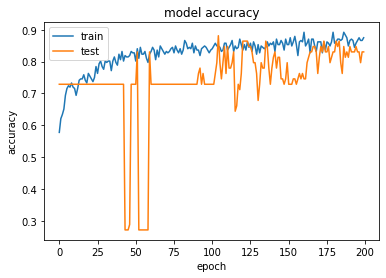

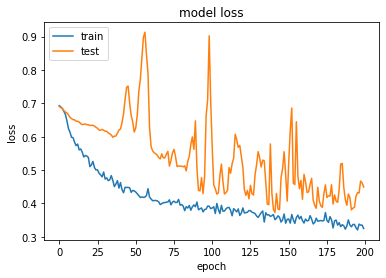

In [147]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Predict

In [140]:
model.load_weights('/content/tmp/checkpoint.h5')
probs = model.predict(X1_test)

# Result

In [138]:
def report(thres):
    y_pred =(probs>thres)
    print(y_pred[:,-1].astype(int))
    print(classification_report(y1_test, y_pred))
    return classification_report(y1_test, y_pred)

In [141]:
report(0.5)

[1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0
 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
 0 1 1 1 1 0 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
              precision    recall  f1-score   support

           0       0.30      0.08      0.13        96
           1       0.60      0.88      0.71       153

   micro avg       0.57      0.57      0.57       249
   macro avg       0.45      0.48      0.42       249
weighted avg       0.49      0.57      0.49       249
 samples avg       0.57      0.57      0.57       249



'              precision    recall  f1-score   support\n\n           0       0.30      0.08      0.13        96\n           1       0.60      0.88      0.71       153\n\n   micro avg       0.57      0.57      0.57       249\n   macro avg       0.45      0.48      0.42       249\nweighted avg       0.49      0.57      0.49       249\n samples avg       0.57      0.57      0.57       249\n'

In [ ]:
with open('readme.txt', 'a') as f:
    f.write(' '.join(channels3))
    f.write('\n')
    f.write(report(0.5))

[1 0 1 1 1 0 1 1 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 1 1 0 0 1 1 1 0 0 0 1 1 0 1 1 0 0 1 1 1 0 1 1 1 0 1 1 0 1 1 1 1 0
 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
              precision    recall  f1-score   support

           0       0.91      0.50      0.65        40
           1       0.73      0.96      0.83        57

   micro avg       0.77      0.77      0.77        97
   macro avg       0.82      0.73      0.74        97
weighted avg       0.81      0.77      0.76        97
 samples avg       0.77      0.77      0.77        97



In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [24]:
from sklearn import decomposition, datasets
from sklearn.pipeline import Pipeline
from sklearn import svm

svc = svm.SVC()
# pca = decomposition.PCA()

# pipe = Pipeline(steps=[('pca', pca), ('svc', svc)])


In [136]:
X1, y1= getData(loadData(1), pick_channels=channels3)

Reading /content/drive/MyDrive/ERN-Data/sub-001/eeg/sub-001_task-ERN_eeg.fdt
Adding metadata with 14 columns
Replacing existing metadata with 14 columns
388 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 388 events and 1025 original time points ...
    Rejecting  epoch based on EEG : ['FP1', 'FP2', 'F8', 'VEOG_lower']
    Rejecting  epoch based on EEG : ['FP2', 'F4', 'F8', 'C6', 'HEOG_left', 'HEOG_right', 'VEOG_lower']
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['FP1', 'FP2', 'VEOG_lower']
    Rejecting  epoch based on EEG : ['FP2', 'F8', 'VEOG_lower']
    Rejecting  epoch based on EEG : ['FP1', 'F7', 'FP2', 'F8', 'VEOG_lower']
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['VEOG_lower']
    Rejecting  epoch based on EEG : ['FP2', 'F8', 'VEOG_lower']
    Rejecting  epoch 

In [137]:
X1_test =  X1.reshape(X1.shape[0], chans, samples, kernels)
y1_test = np_utils.to_categorical(y1)

In [91]:
a= X.reshape((X.shape[0], X.shape[1]*X.shape[2]))

In [71]:
a

array([[ 5.85975610e-07,  1.67972561e-06,  7.10975610e-07, ...,
        -1.55044207e-05, -1.61919207e-05, -1.64419207e-05],
       [ 1.86605183e-05,  8.59801829e-06,  4.97301829e-06, ...,
         1.34791159e-05,  1.65103659e-05,  1.62916159e-05],
       [-3.18475610e-06, -1.52850610e-06, -1.59100610e-06, ...,
        -1.77713415e-06, -2.08963415e-06, -1.71463415e-06],
       ...,
       [ 1.47131193e-05,  1.05256193e-05,  7.11936928e-06, ...,
        -9.46295732e-06, -7.96295732e-06, -7.36920732e-06],
       [ 1.38573742e-06,  2.04198742e-06,  2.41698742e-06, ...,
        -7.99542683e-06, -9.43292683e-06, -1.07141768e-05],
       [ 2.25872618e-05,  2.19935118e-05,  2.18685118e-05, ...,
        -1.17179878e-05, -1.19992378e-05, -1.35929878e-05]])

In [92]:
svc.fit(a,y)

SVC()

In [82]:
a.shape

(388, 16400)

In [35]:
import numpy as np

In [73]:
X1.shape

(388, 16, 1025)

In [68]:
X.shape

(388, 16, 1025)

In [101]:
probs = svc.predict(X1.reshape((X1.shape[0], X.shape[1]*X.shape[2])))
# y_val = np.argmax(y_val, axis=1)

In [102]:
probs

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [103]:
y1

array([1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1,
       1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0,
       1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1,
       1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,

In [96]:
print(classification_report(probs,y1))

              precision    recall  f1-score   support

           0       0.01      0.40      0.03         5
           1       0.99      0.64      0.78       383

    accuracy                           0.64       388
   macro avg       0.50      0.52      0.40       388
weighted avg       0.98      0.64      0.77       388



In [ ]:
model.fit_transform(X,y)

ValueError: ignored